# Hands-On 1: Neural networks for regression - simple energy reconstruction

Neural networks often solve two sets of problems: classification or regression. Typical regression taks are energy, angular or Xmax reconstruction (see hands-on 3). Today we will cover a very basic regression problem and reconstruct the energy of artificially generated cosmic-ray data. The real-world example using TA data will be discussed on Friday.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


### 1. Generate artificial data

In our example, the energy is estimated from the number of muons and the arrival angle.

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Generate synthetic cosmic ray shower data
def generate_cosmic_ray_data(n_samples=100):
    # Generate random parameters: number of muons, shower angles (in radians)
    num_muons = torch.randint(10, 100, (n_samples, 1)).float()  # Random number of muons
    arrival_angle = torch.rand(n_samples, 1) * 2 * 3.14159  # Random angle between 0 and 2π

    # Simulated energy reconstruction: E = a * num_muons^2 + b * angle + c
    a, b, c = 0.5, 1.0, 10.0
    energy = a * (num_muons ** 2) + b * arrival_angle + c

    return torch.cat((num_muons, arrival_angle), dim=1), energy

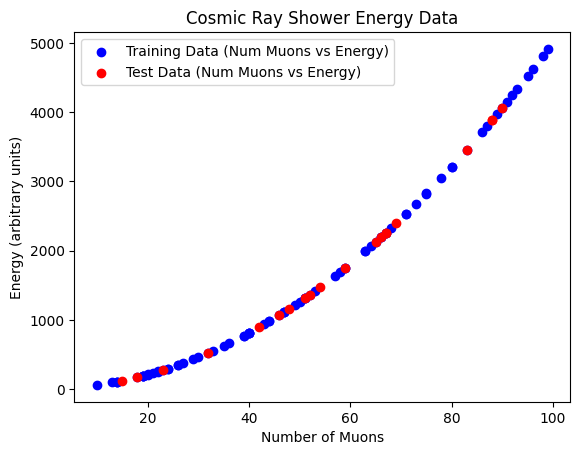

In [3]:
# Generate training and test data
n_train = 80
n_test = 20
X_train, y_train = generate_cosmic_ray_data(n_samples=n_train)
X_test, y_test = generate_cosmic_ray_data(n_samples=n_test)

# Visualize the generated data
plt.scatter(X_train[:, 0].numpy(), y_train.numpy(), label="Training Data (Num Muons vs Energy)", color='blue')
plt.scatter(X_test[:, 0].numpy(), y_test.numpy(), label="Test Data (Num Muons vs Energy)", color='red')
plt.title("Cosmic Ray Shower Energy Data")
plt.xlabel("Number of Muons")
plt.ylabel("Energy (arbitrary units)")
plt.legend()
plt.show()

### 2. Create a simple neural network

We already know the structure of a simple neural network from the classification of hand-written digits and can create a similar structure. Neural networks are essentially the same for regression and classification. However, the main difference is the output layer of the network. Regression predicts continuous values as a real-valued number. Classification predicts discrete categories in terms of a class label or a probability distribution. These differences require different output layers. Here the network has a single neuron in the output layer with a linear activation function (e.g., no activation or identity function) to produce a continuous output.

In [4]:
class CosmicRayNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CosmicRayNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)  # Output layer (no activation)
        return x

In [5]:
# Initialize the model, loss function, and optimizer
input_size = 2  # Two input features: number of muons and arrival angle
hidden_size = 64
model = CosmicRayNN(input_size, hidden_size)
print(model)

CosmicRayNN(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


### 3. Train and evaluate model

Another main difference between neural networks for regression and classification is the loss function. Classification uses loss functions suited for categorical outputs, such as Cross-Entropy Loss or Binary Cross-Entropy Loss for binary classification. Regression tasks require loss functions suitable for continuous outputs, such as Mean Squared Error (MSE) or Mean Absolute Error (MAE). More losses are introduced in hands-on 3.

In [6]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training function
def train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs=100):
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    model.train()
    losses = []
    for epoch in range(epochs):
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Record the loss
        losses.append(loss.item())
        
        # Print loss for every 10th epoch
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return losses

# Evaluation function
def evaluate_cosmic_ray_model(model, X_test, y_test, criterion):
    model = model.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
    print(f'Test Loss: {loss.item():.4f}')
    return outputs


In [7]:
def loss_function_plot(epochs,losses):
    plt.plot(range(epochs), losses)
    plt.title("Loss Curve during Training")
    plt.xlabel("Epochs")
    #plt.yscale('log')
    plt.ylabel("Mean Squared Error Loss")
    plt.show()

Epoch [10/100], Loss: 4502068.5000
Epoch [20/100], Loss: 4459221.5000
Epoch [30/100], Loss: 4415006.5000
Epoch [40/100], Loss: 4364035.5000
Epoch [50/100], Loss: 4299461.0000
Epoch [60/100], Loss: 4218790.0000
Epoch [70/100], Loss: 4119846.7500
Epoch [80/100], Loss: 4000748.7500
Epoch [90/100], Loss: 3859855.7500
Epoch [100/100], Loss: 3695940.0000


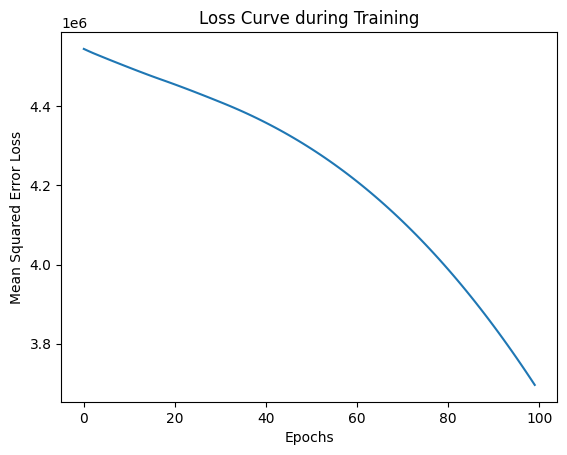

In [8]:
# Train the model and plot the loss curve
epochs = 100
losses = train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the loss curve
loss_function_plot(epochs,losses)

In [9]:
# Evaluate the model on the test set
outputs = evaluate_cosmic_ray_model(model, X_test, y_test, criterion)

# Print a few predictions vs actual values
print("\nSample Predictions vs Actual Values:")
for i in range(10):
    print(f"Predicted: {outputs[i].item():.3f}, Actual: {y_test[i].item():.3f}")


Test Loss: 3879086.7500

Sample Predictions vs Actual Values:
Predicted: 256.208, Actual: 2191.871
Predicted: 348.416, Actual: 4064.764
Predicted: 92.754, Actual: 278.211
Predicted: 257.760, Actual: 2256.523
Predicted: 321.859, Actual: 3459.281
Predicted: 75.083, Actual: 176.793
Predicted: 268.139, Actual: 2394.816
Predicted: 186.310, Actual: 1164.590
Predicted: 201.157, Actual: 1364.310
Predicted: 62.096, Actual: 125.978


## Exercise: Parameter-tuning

Perform a hyperparameter search to improve the prediction.

In [10]:
class CosmicRayNN(nn.Module):
    def __init__(self, hidden_units):
        super(CosmicRayNN, self).__init__()
        self.fc1 = nn.Linear(2, hidden_units)  # Input layer to hidden layer (2 features)
        self.fc2 = nn.Linear(hidden_units, 1)   # Hidden layer to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function
        x = self.fc2(x)               # Output layer
        return x

In [11]:
def train_model(model, X_train, y_train, criterion, optimizer, epochs=100):
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_train)  # Forward pass
        loss = criterion(outputs, y_train)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

def evaluate_model(model, X_test, y_test, criterion):
    model = model.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
    return loss.item()

In [12]:
def hyperparameter_tuning(X_train, y_train, X_test, y_test):
    learning_rates = [0.01, 0.001]  # Different learning rates
    hidden_units_list = [4, 8, 16]  # Different numbers of hidden units
    epochs = 100

    # Initialize the best model and metrics
    best_model = None
    best_loss = float('inf')

    # Hyperparameter tuning
    for lr in learning_rates:
        for hidden_units in hidden_units_list:
            model = CosmicRayNN(hidden_units)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Train the model
            train_model(model, X_train, y_train, criterion, optimizer, epochs)

            # Evaluate the model on the test set
            val_loss = evaluate_model(model, X_test, y_test, criterion)

            print(f'Learning Rate: {lr}, Hidden Units: {hidden_units}, Test Loss: {val_loss:.4f}')

            # Check if the current model is the best
            if val_loss < best_loss:
                best_loss = val_loss
                best_model = model

    print("Best Model Achieved Test Loss:", best_loss)
    return best_model



In [13]:
best_model = hyperparameter_tuning(X_train, y_train, X_test, y_test)

Learning Rate: 0.01, Hidden Units: 4, Test Loss: 4820903.5000
Learning Rate: 0.01, Hidden Units: 8, Test Loss: 3297722.5000
Learning Rate: 0.01, Hidden Units: 16, Test Loss: 1193014.3750
Learning Rate: 0.001, Hidden Units: 4, Test Loss: 4859008.5000
Learning Rate: 0.001, Hidden Units: 8, Test Loss: 4689967.0000
Learning Rate: 0.001, Hidden Units: 16, Test Loss: 4729078.0000
Best Model Achieved Test Loss: 1193014.375


**Learning Rates**: We tested two learning rates, 0.01 and 0.001.
A lower learning rate often allows for more fine-tuned adjustments to the weights but may lead to longer training times, while a higher learning rate can accelerate convergence but might overshoot optimal solutions.

**Hidden Units**: We varied the number of hidden units in the first hidden layer from 4 to 16. Increasing the number of hidden units allows the model to capture more complex patterns in the data, but it also increases the risk of overfitting, especially if the training data is limited.


**Performance Metrics**: After training, we evaluated the model on the test set using mean squared error (MSE) as the loss metric. The results indicated that certain combinations of learning rates and hidden units yielded lower test losses, indicating better generalization to unseen data. The best-performing model was determined by the configuration that minimized the validation loss.

In [14]:
# Evaluate the model on the test set
outputs = evaluate_cosmic_ray_model(best_model, X_test, y_test, criterion)

# Print a few predictions vs actual values
print("\nSample Predictions vs Actual Values:")
for i in range(10):
    print(f"Predicted: {outputs[i].item():.3f}, Actual: {y_test[i].item():.3f}")


Test Loss: 1193014.3750

Sample Predictions vs Actual Values:
Predicted: 1289.818, Actual: 2191.871
Predicted: 1744.852, Actual: 4064.764
Predicted: 495.845, Actual: 278.211
Predicted: 1280.899, Actual: 2256.523
Predicted: 1616.234, Actual: 3459.281
Predicted: 419.784, Actual: 176.793
Predicted: 1351.627, Actual: 2394.816
Predicted: 939.498, Actual: 1164.590
Predicted: 1008.999, Actual: 1364.310
Predicted: 345.116, Actual: 125.978
